In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10, cifar100
from tqdm.notebook import tqdm 

In [38]:
# Cargar el conjunto de datos CIFAR-10
(x_train, y_train), (_, _) = cifar100.load_data()

# Seleccionar las primeras 100 imágenes del conjunto de entrenamiento
num_images = 10000
x_subset = x_train[:num_images]
y_subset = y_train[:num_images]

# Verificar las dimensiones del subconjunto
print("Dimensiones del subconjunto de imágenes:", x_subset.shape)  # Debería ser (100, 32, 32, 3) para CIFAR-10

# Ahora x_subset contiene las primeras 100 imágenes y y_subset contiene las etiquetas correspondientes
# Puedes usar x_subset e y_subset en tu código para trabajar con estas imágenes.


Dimensiones del subconjunto de imágenes: (10000, 32, 32, 3)


<AxesSubplot:>

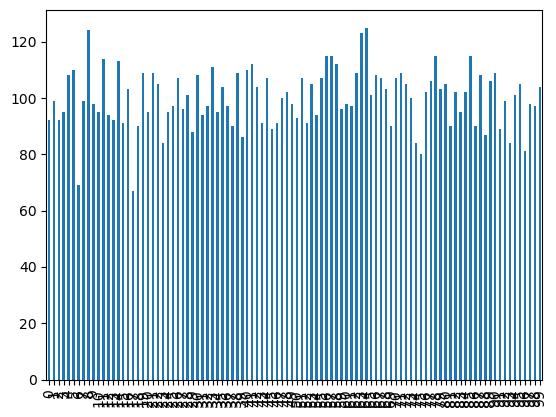

In [41]:
pd.value_counts(y_subset.flatten() , sort = False).sort_index().plot(kind='bar')

In [47]:
# Función para convertir imágenes a escala de grises y aplicar SIFT
def convert_to_gray_and_apply_sift(images):
    descriptors_list = []
    sift = cv2.SIFT_create()
    indice_imagen = []
    for idx, img in tqdm(enumerate(images), total = len(images)):
        # Convertir la imagen a escala de grises
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # gray_img = cv2.resize()

        # Aplicar SIFT en la imagen en escala de grises
        _, descriptors = sift.detectAndCompute(gray_img, None)

        if descriptors is None: continue    
        
        descriptors_list.append(descriptors)
        indice_imagen += [idx] * descriptors.shape[0]


    return descriptors_list, indice_imagen

# Convertir las imágenes a escala de grises y aplicar SIFT en el subconjunto de imágenes
descriptors_list, index = convert_to_gray_and_apply_sift(x_subset)

print("Dimensiones del descriptor de la primera imagen:", descriptors_list[1].shape)


  0%|          | 0/10000 [00:00<?, ?it/s]

Dimensiones del descriptor de la primera imagen: (13, 128)


In [48]:
pd.value_counts([v.shape[0] for v in descriptors_list]).sort_index()

1     103
2     139
3     161
4     229
5     311
6     409
7     441
8     522
9     567
10    657
11    707
12    672
13    717
14    716
15    627
16    599
17    508
18    432
19    332
20    293
21    220
22    166
23    137
24     75
25     48
26     53
27     28
28     17
29     12
30      3
31      5
32      3
33      4
34      2
35      1
36      1
38      1
40      1
48      1
52      1
69      1
dtype: int64

In [49]:
descriptors = np.concatenate(descriptors_list) # index

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\ruben\anaconda3\envs\min-data\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


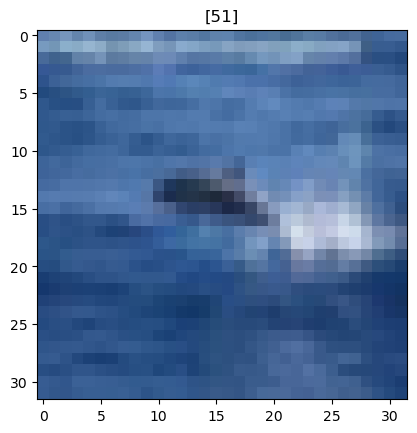

In [54]:
test_image = x_train[10002]
descriptor_busqueda,_ = convert_to_gray_and_apply_sift([test_image])

plt.imshow(test_image)
plt.title(y_train[1002]);

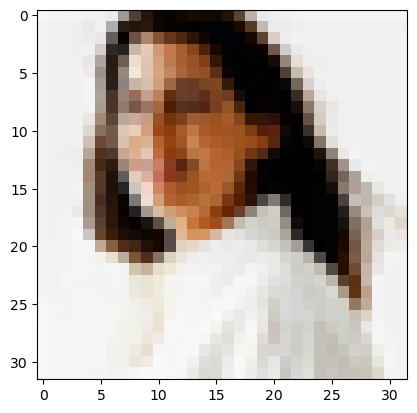

In [56]:
plt.imshow(x_subset[4271])

In [52]:
descriptor_busqueda[0].shape

(13, 128)

In [55]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter

# Crear un modelo de k-NN
knn_model = NearestNeighbors(n_neighbors=30)  # Buscar los 5 vecinos más cercanos
knn_model.fit(descriptors)  # Ajustar el modelo a los descriptores

# Función para encontrar los vecinos más cercanos para un descriptor dado
def find_nearest_neighbors(descriptor, k = 10):
    descriptor_flat = descriptor.flatten()
    # Encontrar los índices y distancias de los vecinos más cercanos
    distances, indices = knn_model.kneighbors([descriptor_flat], k)  # Obtener k vecinos más cercanos
    return distances, indices

# Ejemplo: Encontrar vecinos más cercanos para el primer descriptor en la primera imagen
contador = Counter()
lista = []
print(len(descriptor_busqueda[0]))
for descriptor in descriptor_busqueda[0]:
    distances, indices = find_nearest_neighbors(descriptor, 20)
    lista.extend([index[indice] for indice in indices[0]])

print(len(lista))
Counter(lista).most_common(10)
# Imprimir los índices de los vecinos más cercanos y sus distancias
#print("Índices de los vecinos más cercanos:", indices)
#print("Distancias a los vecinos más cercanos:", distances)


9
180


[(4271, 2),
 (6628, 2),
 (2129, 2),
 (7308, 2),
 (7705, 2),
 (3649, 2),
 (6184, 2),
 (8674, 2),
 (9719, 2),
 (6249, 2)]